### eye-tracking
This project is an implementation of eye tracking software. More specifically, using a laptop webcam to track where on the screen someone's eyes are looking using a convolutional network. 

Each input image is processed through a face alignment algorithm to crop out a zoomed in frame in each eye and the face overall, along with landmark data. Each of those frames is processed through a convolutional network and the landmark data through a few dense layers. Finally, everything is concatenated and processed through a few more dense layers.

The output layer has 2 nodes, one for x and one for y.

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras
from keras.callbacks import TensorBoard
import io
import IPython

from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook as tqdm

import face_alignment
import cv2

Using TensorFlow backend.


In [2]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda')

In [3]:
%%time

x_data = []
y_data = []

if 'data.pickle' in os.listdir():
    with open('data.pickle', 'rb') as f:
        data = list(zip(*pickle.load(f)))
        np.random.shuffle(data)
        x_data, y_data = map(np.array, zip(*data))

Wall time: 15.2 s


In [4]:
# initializing face_alignment takes a while
%time _ = fa.get_landmarks(x_data[1])

Wall time: 14.1 s


In [5]:
def center(landmarks, feature):
    """
    Find the pixel center of a given feature from face_recognition landmarks
    
    :param landmarks: landmarks generated with face_recognition.face_landmarks
    :param feature: the relevant facial feature. Called 'feature' and not 'landmark' to avoid confusion
    :return: pixel center
    """
    return np.mean(landmarks[0][feature], axis=0)
    

def crop_part(image, landmark, landmarks=None, scale=(64, 64)):
    if landmarks is None:
        landmarks = fa.get_landmarks(image)
        
    scale = tuple(map(int, scale))
    
    # calculate top-left corner of crop area
    pos = center(landmarks, landmark) - np.array([scale[0], scale[0]]) / 2
    x, y = tuple(map(int, pos))
    
    # crop image using slicing
    out = image[y:y+scale[0]].swapaxes(0, 1)[x:x+scale[0]].swapaxes(0, 1)
    
    # if necessary, rescale image before outputting
    if scale[0] != scale[1]:
        out = cv2.resize(out, dsize=(scale[1], scale[1]), interpolation=cv2.INTER_CUBIC)
    
    return out

def get_inputs(image, crash=False, out_size=128):
    """
    Given an image, returns cropped areas and data relevant to eye tracking.
    
    :param image: image to search
    :param crash: if the function should crash or return None given an invalid image
    :return: left_eye, right_eye, face, aux_data
    """
    landmarks = fa.get_landmarks(image)
    
    nose = range(27, 36)
    l_eye = range(36, 42)
    r_eye = range(42, 48)
    
    if landmarks or crash:
        # calculate distance between center of eyes to establish relative scale
        dist = np.linalg.norm(center(landmarks, l_eye) - center(landmarks, r_eye))

        if crash:
            left_eye  = crop_part(image, l_eye, landmarks, scale=(dist*0.6, out_size))
            right_eye = crop_part(image, r_eye, landmarks, scale=(dist*0.6, out_size))
            face      = crop_part(image, nose, landmarks, scale=(dist*2, out_size))
        else:
            try:
                # pull out each cropped detail
                left_eye  = crop_part(image, l_eye, landmarks, scale=(dist*0.6, out_size))
                right_eye = crop_part(image, r_eye, landmarks, scale=(dist*0.6, out_size))
                face      = crop_part(image, nose, landmarks, scale=(dist*2, out_size))
            except:
                return None

        # flip right to maximize similarity
        right_eye = np.fliplr(right_eye)

        # calculate some relevant data: 
        #   distance between eyes -- scale of face
        #   all points in the landmark data -- abstract face shape view
        aux_data = [dist, *landmarks[0].flat]

        return left_eye, right_eye, face, aux_data
    else:
        return None

In [6]:
# I'm like 60% sure this increases framerate
def array_to_img(a, fmt='jpeg'):
    f = io.BytesIO()
    keras.preprocessing.image.array_to_img(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

In [7]:
gen = zip(map(get_inputs, tqdm(x_data)), y_data)
gen = filter(lambda x: x[0], gen)
temp, targets = zip(*gen)
inputs = [*map(np.array, zip(*temp))]
targets = np.array(targets)
# left_eye, right_eye, face, aux_data = inputs

In [8]:
from keras.models import Model
from keras.layers import (Input, Dense, Conv2D, Flatten, GaussianNoise,
                          Concatenate, MaxPooling2D, Dropout, BatchNormalization)
import keras.backend as K

In [153]:
layer = GaussianNoise(0.5)

In [150]:
# This network consists of three parts:
#  * conv-nets on both eyes - directly detect which way they look
#  * conv-net on entire face - detect face/head orientation
#  * location/size of head
# All parts are at the end stiched together into a few dense layers

left_input = Input((128, 128, 3))
right_input = Input((128, 128, 3))

# shared networks/weights between both eyes
eye_layers = [
    GaussianNoise(0.5),
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),
#     Dropout(0.25),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=2),
    Dropout(0.25),
    Conv2D(348, (3, 3), activation='relu', padding='same'),
    Dropout(0.25),
    Conv2D(64, (1, 1), activation='relu'),
    GaussianNoise(0.5),
    BatchNormalization() # +
]

le = left_input
for layer in eye_layers:
    le = layer(le)

re = right_input
for layer in eye_layers:
    re = layer(re)

# combine both eyes into a dense layer
eyes = Concatenate()([le, re])
eyes = Dense(128, activation='relu')(eyes)
eyes = BatchNormalization()(eyes)
eyes = Flatten()(eyes)

# identical (but separate) network for the face
face_input = Input((128, 128, 3))

f = face_input
f = GaussianNoise(0.5)(f)
f = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling2D((3, 3), 2)(f)
# f = Dropout(0.25)(f)
f = Conv2D(256, (5, 5), activation='relu', padding='same')(f)
f = MaxPooling2D((3, 3), 2)(f)
f = Dropout(0.25)(f)
f = Conv2D(348, (3, 3), activation='relu', padding='same')(f)
f = Dropout(0.25)(f)
f = Conv2D(128, (1, 1), activation='relu')(f)
f = GaussianNoise(0.5)(f)
f = BatchNormalization()(f) # +


f = Dense(128, activation='relu')(f)
f = BatchNormalization()(f)
f = GaussianNoise(1)(f)
# f = Dropout(0.25)(f)
f = Dense(64, activation='relu')(f)
f = BatchNormalization()(f)
f = Flatten()(f)


# TODO: try using a binary mask face grid instead
data_input = Input((1+136, ))
data = Dense(64, activation='relu')(data_input)
data = BatchNormalization()(data)

full = Concatenate()([eyes, f, data])

full = Dense(128, activation='relu')(full)
full = BatchNormalization()(full)
full = GaussianNoise(0.5)(full)

# full = Dense(48 * 27, activation='relu')(full)
# full = Dropout(0.25)(full)
# full = Dense(128, activation='relu')(full)
# full = Dropout(0.5)(full)

# A sigmoid activation function results 
full = Dense(2, activation='sigmoid')(full)

model = Model(inputs=[left_input, right_input, face_input, data_input], outputs=[full])


opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(loss='mean_squared_error',
              optimizer=opt,
             metrics=[])

In [117]:
temp = model

In [9]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stderr():
    with open(os.devnull, "w") as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:  
            yield
        finally:
            sys.stderr = old_stderr

In [10]:
from keras.models import load_model
with suppress_stderr():
    linear = load_model('linear.h5')
print('linear model loaded')
with suppress_stderr():
    sigmoid = load_model('sigmoid.h5')
print('sigmoid model loaded')

linear model loaded
sigmoid model loaded


In [29]:
model=linear

In [118]:
model=sigmoid

`TQDMNotebookCallback` is a bit buggy with my setup and adds extra space each epoch. This CSS resolves that.

In [123]:
%%html
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>

In [139]:
tensorboard = TensorBoard(batch_size=64,
                          update_freq='epoch',
                          write_graph=False)

In [151]:
# TODO: batch normalization to renormalize network (+ can do higher learning rate) --==DONE==--
# TODO: gradient noise to deal with poor initialization (ESCAPE THE LOCAL MINIMUM OF PUTTING EVERYTHING IN CENTER)
hist = model.fit(inputs, targets / np.array([1920, 1080]),
                 batch_size=64, epochs=10, validation_split=0.2,
                 verbose=0, callbacks=[TQDMNotebookCallback(), tensorboard])

In [152]:
model.evaluate(inputs, targets / np.array([1920, 1080]), verbose=0)

0.06314255777921797

In [168]:
linear.save('linear.h5')
sigmoid.save('sigmoid.h5')

In [131]:
from matplotlib import pyplot as plt
from scipy import stats

part = int(0.2*len(targets))
pred, actual = model.predict(inputs) * np.array([1920, 1080]), targets

In [132]:
a = list(enumerate(np.linalg.norm(pred - actual, axis=1)))
a.sort(key=(lambda x: x[1]), reverse=True)
a[0:10]

[(1095, 2181.7413328233533),
 (769, 2180.5820178689432),
 (993, 2180.5820178689432),
 (1050, 2180.5820178689432),
 (1074, 2180.5820178689432),
 (1586, 2180.5820178689432),
 (3008, 2180.5820178689432),
 (535, 2180.4947241637833),
 (479, 2179.8057970154496),
 (150, 2178.626674675865)]

In [133]:
def scatter_view(ax, data, margin=100, title=None):
    alpha = 200 / len(data)
    ax.scatter(*zip(*data), s=50, alpha=alpha)
    ax.set_ylim([0-margin, 1080+margin])
    ax.set_xlim([0-margin, 1920+margin])
    ax.axvline(0)
    ax.axvline(1920)
    ax.axhline(0)
    ax.axhline(1080)
    ax.set_xticks([0, 1920])
    ax.set_yticks([0, 1080])
    ax.set_title(title)

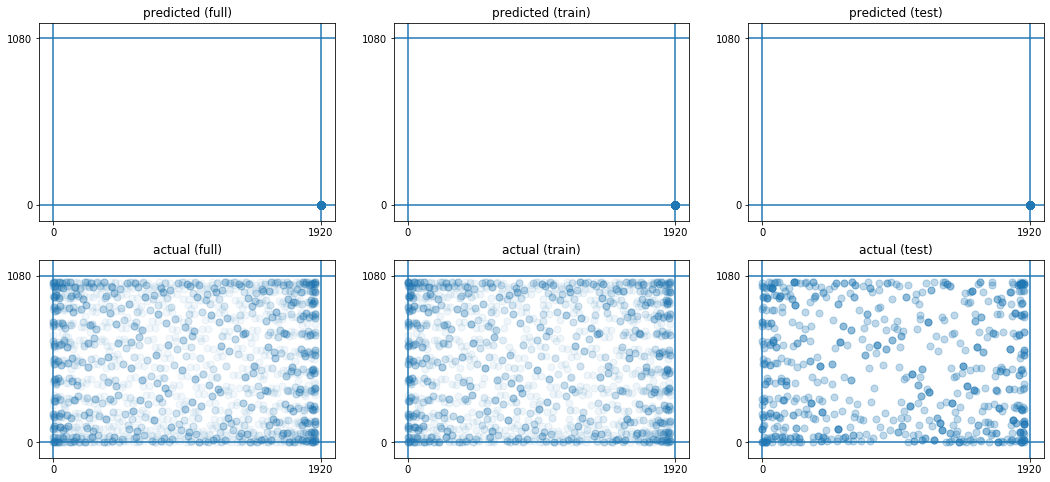

In [134]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[18, 8])

scatter_view(ax[0][0], pred, title='predicted (full)')
scatter_view(ax[1][0], actual, title='actual (full)')

scatter_view(ax[0][1], pred[:-part], title='predicted (train)')
scatter_view(ax[1][1], actual[:-part], title='actual (train)')

scatter_view(ax[0][2], pred[-part:], title='predicted (test)')
scatter_view(ax[1][2], actual[-part:], title='actual (test)')


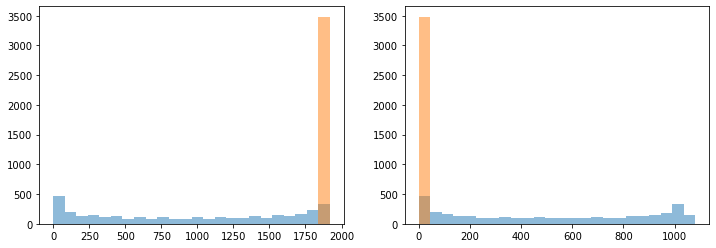

In [135]:
xp, yp = zip(*pred)
xa, ya = zip(*actual)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])

ax[0].hist(xa, bins=24, range=(0, 1920), alpha=0.5)
ax[0].hist(xp, bins=24, range=(0, 1920), alpha=0.5)

ax[1].hist(ya, bins=24, range=(0, 1080), alpha=0.5)
ax[1].hist(yp, bins=24, range=(0, 1080), alpha=0.5)

plt.show()

The following graphs seem to approximate the general shape activation function selected for the output layer. Thus, if specific biases are present in the results, it may be possible to counteract them by either selecting a different activation function or creating an adaptive activation function if necessary. 

In [110]:
def compare_actual_pred(ax, actual, pred, title=None):
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(list(zip(*actual))[0], list(zip(*pred))[0])

    ax[0].set_title(title)
    
    ax[0].scatter(list(zip(*actual))[0], list(zip(*pred))[0], alpha=0.1)
    a = np.linspace(0, 1920)
    ax[0].plot(a, a * slope + intercept)
    ax[0].plot(a, a)
    ax[0].set_ylim([0, 1920])
    ax[0].set_xlim([0, 1920])
    ax[0].set_xlabel('rvalue: {0:.2f}'.format(rvalue))

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(list(zip(*actual))[1], list(zip(*pred))[1])
    ax[1].scatter(list(zip(*actual))[1], list(zip(*pred))[1], alpha=0.1)
    a = np.linspace(0, 1080)
    ax[1].plot(a, a * slope + intercept)
    ax[1].plot(a, a)
    ax[1].set_ylim([0, 1080])
    ax[1].set_xlim([0, 1080])
    ax[1].set_xlabel('rvalue: {0:.2f}'.format(rvalue))

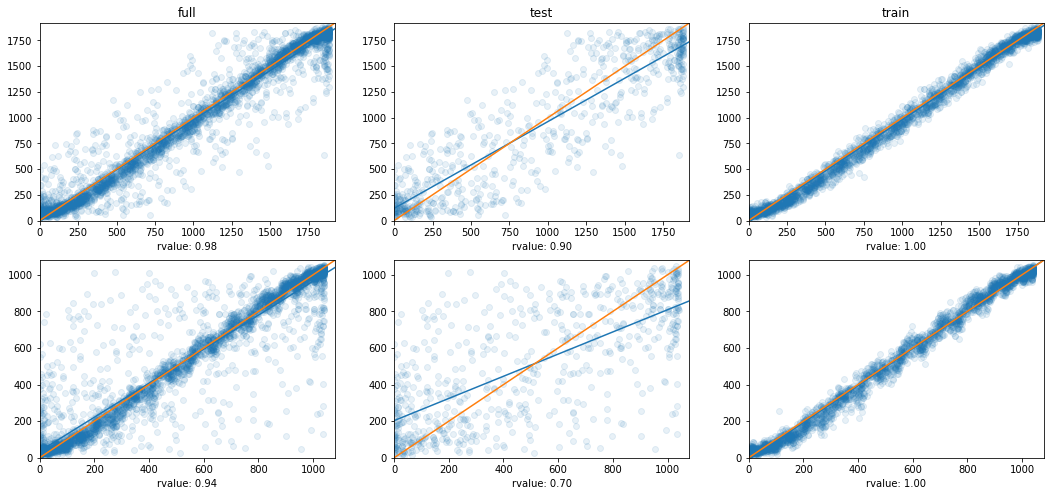

In [111]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[18, 8])

compare_actual_pred((ax[0][0], ax[1][0]), actual, pred, title='full')
compare_actual_pred((ax[0][1], ax[1][1]), actual[-part:], pred[-part:], title='test')
compare_actual_pred((ax[0][2], ax[1][2]), actual[:-part], pred[:-part], title='train')

In [34]:
def predict_view(n=5):
    arr = []
    for _ in range(n):
        s, frame = cam.read()
        if s:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            parts = get_inputs(frame, crash=False, out_size=128)
            if parts is not None:
                left_eye, right_eye, face, location = parts
                left_eye = np.array([left_eye])
                right_eye = np.array([right_eye])
                face = np.array([face])
                location = np.array([location])
                arr.append(model.predict([left_eye, right_eye, face, location]) * np.array([1920, 1080]))
    
    if len(arr) == 0:
        return (0, 0)
    else:
        return np.median(np.array(arr).reshape(-1, 2), axis=0)

In [35]:

import pygame
from pygame.locals import QUIT, KEYDOWN

import time
import cv2

if 'cam' in vars():
    cam.release()
cam = cv2.VideoCapture(0)

def main(n=10):
    pygame.init()
    cam.read()

    DISPLAY=pygame.display.set_mode((1920,1080),0,32)

    WHITE=(255,255,255)
    BLUE=(0,0,255)
    LIGHT_BLUE=(240,240,255)
    

    DISPLAY.fill(WHITE)
    
    rolling = []
    
    while True:
        for event in pygame.event.get():
            if event.type==KEYDOWN:
                if event.scancode == 119:
                    cam.release()
                    pygame.quit()
                    return
            if event.type==QUIT:
                cam.release()
                pygame.quit()
                return
        
        try:
            x, y = predict_view(n=1)
            if (x, y) != (0, 0):
                DISPLAY.fill(WHITE)
                x = 1920 - x
                y = 1080 - y
                
                x = (x - 20) * 1
                y = (y - 20) * 1
                
                x = np.clip(x, 0, 1880)
                y = np.clip(y, 0, 1040)
#                 pygame.draw.rect(DISPLAY,LIGHT_BLUE,(x,y,40,40))
                
                rolling.append((x, y))
                rolling = rolling[-n:]
            
                for point in rolling:
                    pygame.draw.rect(DISPLAY,LIGHT_BLUE,(*point,40,40))
                
                x, y = np.median(rolling, axis=0)
                pygame.draw.rect(DISPLAY,BLUE,(x,y,40,40))

                pygame.display.update()
        except:
            pass
        
    cam.release()
    pygame.quit()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [37]:
model = sigmoid

In [38]:
if 'cam' in vars():
    cam.release()
cam = cv2.VideoCapture(0)

main(n=10)

cam.release()
print('camera released')

camera released


In [23]:
import time
import pygame
import cv2

if 'cam' in vars():
    cam.release()
cam = cv2.VideoCapture(0)

def test_person(n=10, test_points=[(960, 540), (40, 1040), (1880, 40), (40, 40), (1880, 1040)]):
    pygame.init()
    
    # let the camera auto-adjust for lighting    
    for _ in range(10):
            s, frame = cam.read()

    DISPLAY=pygame.display.set_mode((1920,1080),0,32)

    WHITE=(255,255,255)
    BLUE=(0,0,255)
    LIGHT_BLUE=(200,200,255)
    

    DISPLAY.fill(WHITE)
    
    frames = []
    
    for i, point in enumerate(test_points):
        frames.append([])
        
        DISPLAY.fill(WHITE)
        
        x, y = point
        pygame.draw.rect(DISPLAY,BLUE,(x-10, y-10, 20, 20))
        pygame.display.update()
        for _ in range(10):
            s, frame = cam.read()
        time.sleep(0.2)
        
        for _ in range(n):
            s, frame = cam.read()
            if s:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames[-1].append(frame)
    
        pygame.draw.rect(DISPLAY,WHITE,(x-10, y-10, 20, 20))
        pygame.display.update()
        
        if i < len(test_points) - 1:
            next_point = test_points[i+1]
            x, y = next_point
            pygame.draw.rect(DISPLAY,LIGHT_BLUE,(x-10, y-10, 20, 20))
            pygame.display.update()
            time.sleep(0.5)
        
    
    cam.release()
    pygame.quit()
    
    return frames, test_points
    

In [24]:
a = np.arange(8).repeat(8) * 1900/7 + 10
b = np.tile(np.arange(8), 8) * 1060/7 + 10

points = list(zip(a, b))

In [25]:
arr, test_points = test_person(n=5, test_points=points)

In [26]:
pygame.quit()
cam.release()

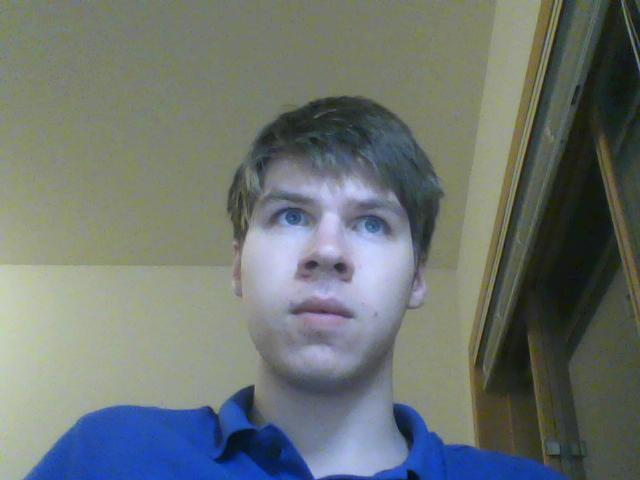

In [27]:
array_to_img(arr[1][3])

In [28]:
test_points

[(10.0, 10.0),
 (10.0, 161.42857142857142),
 (10.0, 312.85714285714283),
 (10.0, 464.2857142857143),
 (10.0, 615.7142857142857),
 (10.0, 767.1428571428571),
 (10.0, 918.5714285714286),
 (10.0, 1070.0),
 (281.42857142857144, 10.0),
 (281.42857142857144, 161.42857142857142),
 (281.42857142857144, 312.85714285714283),
 (281.42857142857144, 464.2857142857143),
 (281.42857142857144, 615.7142857142857),
 (281.42857142857144, 767.1428571428571),
 (281.42857142857144, 918.5714285714286),
 (281.42857142857144, 1070.0),
 (552.8571428571429, 10.0),
 (552.8571428571429, 161.42857142857142),
 (552.8571428571429, 312.85714285714283),
 (552.8571428571429, 464.2857142857143),
 (552.8571428571429, 615.7142857142857),
 (552.8571428571429, 767.1428571428571),
 (552.8571428571429, 918.5714285714286),
 (552.8571428571429, 1070.0),
 (824.2857142857143, 10.0),
 (824.2857142857143, 161.42857142857142),
 (824.2857142857143, 312.85714285714283),
 (824.2857142857143, 464.2857142857143),
 (824.2857142857143, 615.

In [29]:
def predict(model, images, out_size=128):
    gen = map(lambda i: get_inputs(i, False, out_size), images)
    left_eye, right_eye, face, aux_data = map(np.array, zip(*gen))
    
    return model.predict([left_eye, right_eye, face, aux_data])

In [30]:
pred = [predict(model, a) for a in tqdm(arr)]

In [31]:
def transform(point):
    return point
#     return (point - np.array([100, 200]))*np.array([1.1, 2])

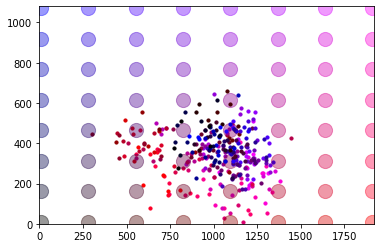

In [32]:

for x, y in zip(transform(pred), test_points):
    y = np.array([1920, 1080]) - y
    z = (y[0] / 1920 * 255, y[1] / 1080 * 255)
    z = tuple(map(int, z))
    c = '#%02x%02x%02x' % (z[0], 0, z[1])
    
    plt.scatter(*y, c=c, s=200, alpha=0.4)
    plt.scatter(*zip(*x), c=c, s=10)


plt.xlim([0, 1920])
plt.ylim([0, 1080])
plt.show()

In [33]:
for x, y in zip(pred, test_points):
    x, y = np.array(x), np.array([1920, 1080]) - np.array(y)
    dists = [np.linalg.norm(point - y) for point in x]
    print(np.mean(dists))

1093.0312104182958
947.0360260256263
901.2682809308669
944.6575789338476
977.6470902412178
1214.0991168691178
1237.6305982421072
1248.6132174971385
859.3442072322741
792.2154172895757
832.7337867037504
644.3841862451095
735.7355188934022
697.3791543229955
1018.3633957219374
1162.8019232445088
739.7558011069865
702.7741583978377
685.1005152179126
534.1170529786194
578.0636889245645
534.3716374950691
837.7027711724638
650.8207120554271
639.4729171143283
474.93210709113663
369.65577004367395
276.1434109238027
175.63420162008723
243.08077770886
578.3789856065936
611.8587727691686
856.2532961846437
694.4833376736362
601.6283817276513
473.7181346429754
363.96837618827396
280.24474922191257
286.24347112180976
509.75536862850305
940.9064512077881
799.2339948434571
770.2324569602215
722.4330511312294
637.9771256803775
596.0817212884406
606.2691299749974
751.0038539513203
1066.1127282177047
1002.0455455403298
949.1852066820645
931.7143070604612
778.5986841689288
776.3141028216917
750.25039681066